# Background

# Dataset

# Objective

# Method

<h1> packages installation </h1>

In [59]:
!pip install kagglehub
!pip install scipy
!pip install seaborn

<h1> Imports </h1>


In [60]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
from sklearn.preprocessing import StandardScaler
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency


<h1> Dataset path </h1>

In [61]:

if 'vscode' in sys.modules:
    DATASET_PATH = './heart.csv'
elif 'google.colab' in sys.modules:
    dataset_folder = kagglehub.dataset_download('fedesoriano/heart-failure-prediction')
    DATASET_PATH = os.path.join(dataset_folder, 'heart.csv')
else:
    raise Exception('Unknown environment')

## Data Exploration and visualization

In [62]:

# Load the dataset
df = pd.read_csv(DATASET_PATH)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


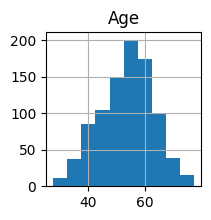

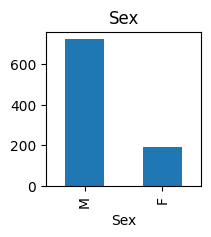

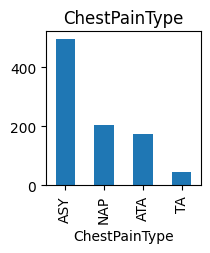

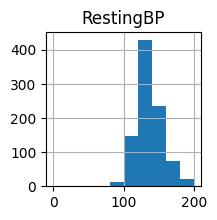

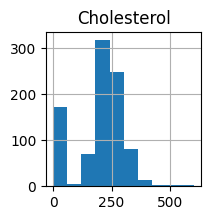

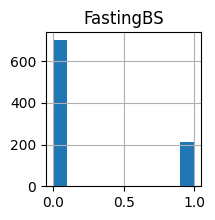

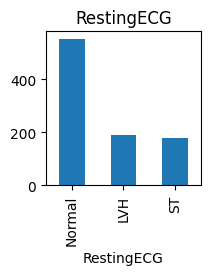

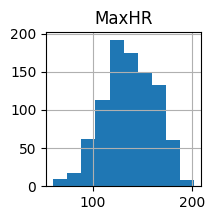

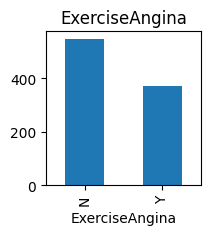

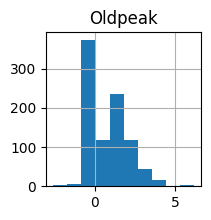

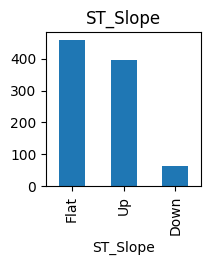

In [63]:
# select all columns except the last one (target)
selected = df.iloc[:,:-1]
# display plot for each column
for column in selected.columns:
    # display a plot depending on the type of the column, catogonal(object) or numerical
    if selected[column].dtype == 'object':
        # frequency plot
        selected[column].value_counts().plot(kind='bar', title=column, figsize=(2, 2))
        plt.show() 
    else:
        # histogram
        selected[column].hist(figsize=(2, 2))
        plt.title(column)  
        plt.show() 



array([[<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>],
       [<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
        <Axes: ylabel='Density'>]], dtype=object)

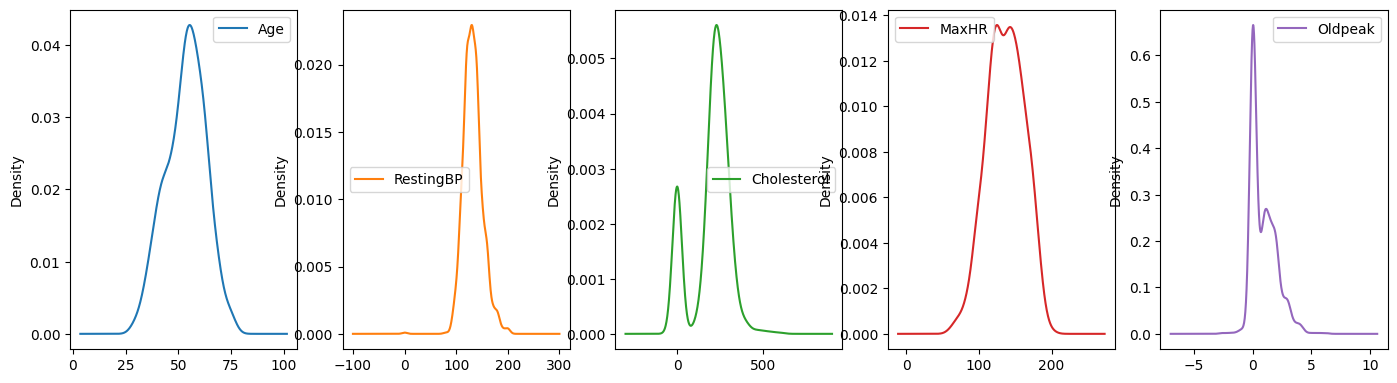

In [64]:
CONTINUOUS_COLUMNS = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
# select all columns except the last one (target)
CATEGORICAL_COLUMNS = df.columns.difference(CONTINUOUS_COLUMNS).difference(['HeartDisease'])
selected = df.loc[:,CONTINUOUS_COLUMNS]
# plot the probability density function for each column
selected.plot(kind='density', subplots=True, layout=(3,5), sharex=False,figsize=(17,15))

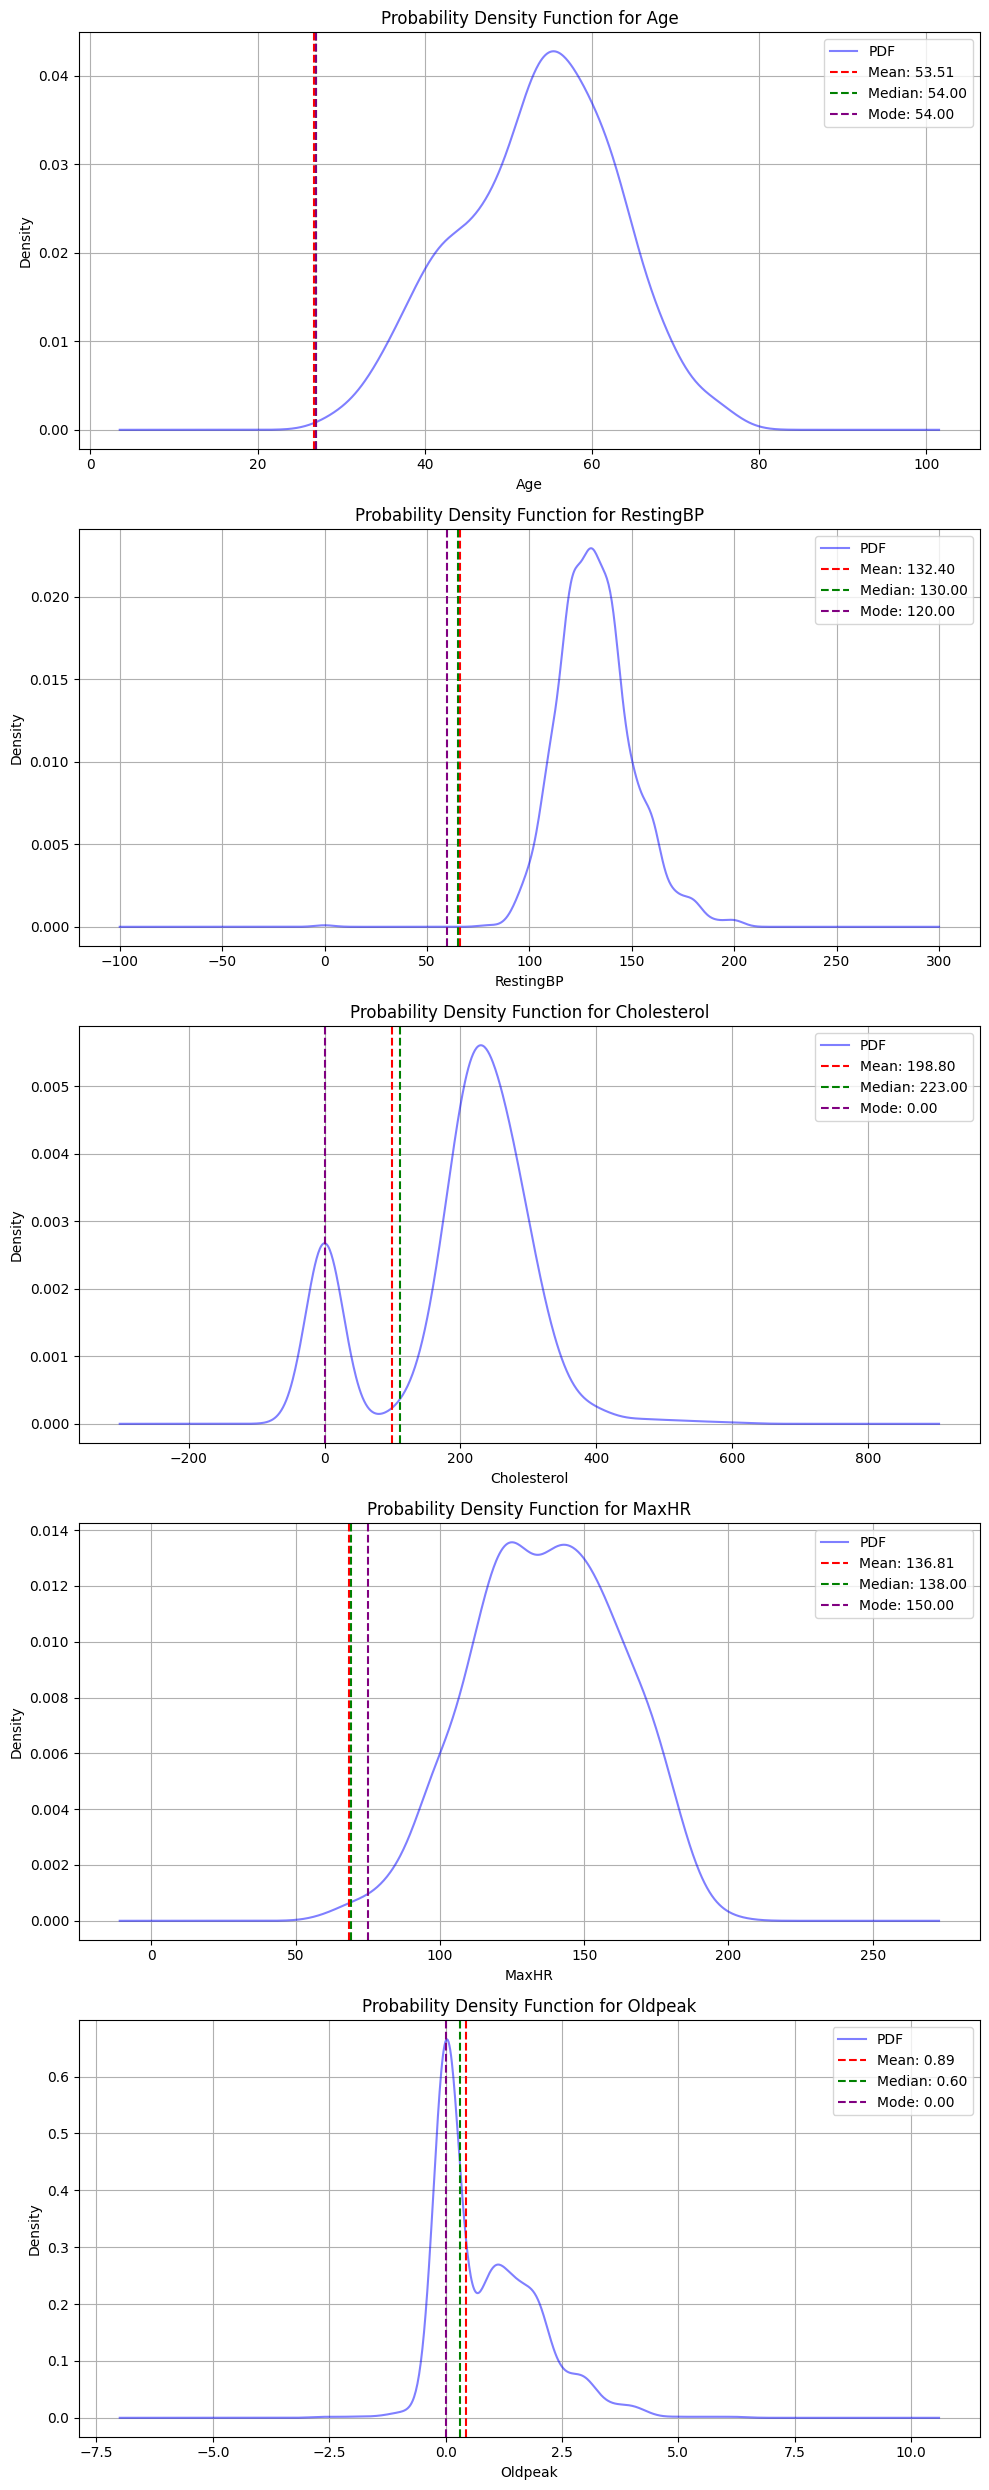

In [65]:
# (this cell does the same thing as the previous cell, but additionally display the mean, median and mode for each column)

# Setting up the plot
num_features = 5
fig, axes = plt.subplots(nrows=num_features, ncols=1, figsize=(10, 5 * num_features))

# Loop through each feature to create a PDF plot
for i, column in enumerate(selected):
    # Plotting the density
    df[column].plot(kind='density', ax=axes[i], color='blue', alpha=0.5, label='PDF')

    # Calculate mean, median, and mode
    mean = df[column].mean()
    median = df[column].median()
    mode = df[column].mode()[0]

    # Marking mean, median, and mode with horizontal lines
    axes[i].axvline(x=mean / 2, color='red', linestyle='--', label=f'Mean: {mean:.2f}')  # Adjusted y-value for visibility
    axes[i].axvline(x=median / 2, color='green', linestyle='--', label=f'Median: {median:.2f}')  # Adjusted y-value for visibility
    axes[i].axvline(x=mode / 2, color='purple', linestyle='--', label=f'Mode: {mode:.2f}')  # Adjusted y-value for visibility

    # Adding titles and labels
    axes[i].set_title(f'Probability Density Function for {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [66]:
# plot the sqewness for each column
selected.skew()

Age           -0.195933
RestingBP      0.179839
Cholesterol   -0.610086
MaxHR         -0.144359
Oldpeak        1.022872
dtype: float64

<h2> Remove Outliers </h2>

In [67]:
# description before removing outliers
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Age               Axes(0.125,0.747241;0.227941x0.132759)
RestingBP      Axes(0.398529,0.747241;0.227941x0.132759)
Cholesterol    Axes(0.672059,0.747241;0.227941x0.132759)
MaxHR             Axes(0.125,0.587931;0.227941x0.132759)
Oldpeak        Axes(0.398529,0.587931;0.227941x0.132759)
dtype: object

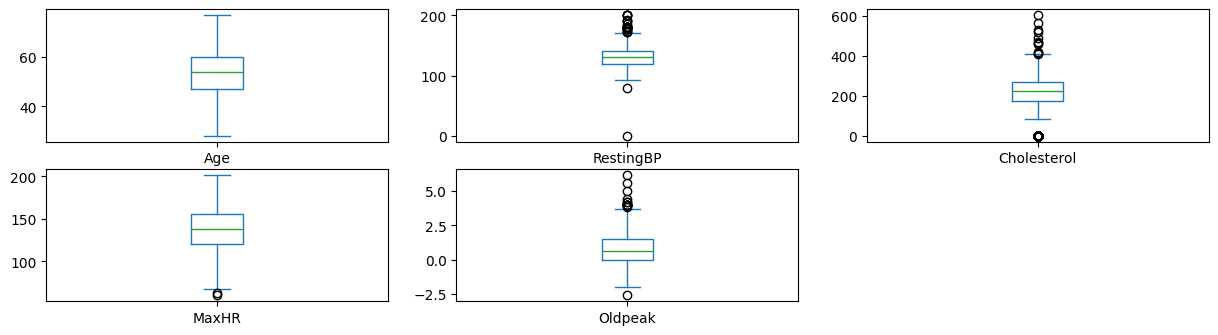

In [68]:
# box plot before removing outliers
selected.plot(kind='box', subplots=True, sharex=False, sharey=False, layout=(5,3), figsize=(15,10))

In [69]:
# -------------------------- remove outliers (should we do it ?????)

def remove_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    return column[(column >= Q1 - 1.5 * IQR) & (column <= Q3 + 1.5 * IQR)]

for column in CONTINUOUS_COLUMNS:
    initial_count = df[column].count()
    df[column] = remove_outliers(df[column])
    final_count = df[column].count()
    print(f'{column}: was {initial_count}, became {final_count}')

#--------------------------- Drop rows with NaN values that resulted from outlier removal
df.dropna(subset=CONTINUOUS_COLUMNS, inplace=True)

# ----------------------------display data after removing outliers

# note that displaying the box plot again has no meaning, since it will show the 
# box plot for the new data after removing the outliers, which may contain new outliers (because the data changed)

# after removing outliers
df.describe()

Age: was 918, became 918
RestingBP: was 918, became 890
Cholesterol: was 918, became 735
MaxHR: was 918, became 916
Oldpeak: was 918, became 902


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000,702.000000
mean,52.722222,131.556980,239.709402,0.162393,140.549858,0.830912,0.462963
std,9.535341,15.420368,50.684118,0.369074,24.360985,0.959731,0.498982
min,28.000000,92.000000,85.000000,0.000000,71.000000,-0.100000,0.000000
25%,46.000000,120.000000,206.000000,0.000000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,235.000000,0.000000,140.000000,0.400000,0.000000
75%,59.000000,140.000000,272.000000,0.000000,160.000000,1.500000,1.000000
max,77.000000,170.000000,404.000000,1.000000,202.000000,3.600000,1.000000


In [70]:
# Check for missing values in each column
df.isnull().sum()

# Visualize missing values using a heatmap (optional)
# sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
# plt.show()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

## Feature extraction and selection

## Data cleaning and processing

### Handling missing data
Given that the dataset contains no missing values for any of the features, there was no need to perform replacement for missing values, dropping any rows with missing values, or dropping any features.

### Dropping Duplicates

In [71]:
num_duplicates = df.duplicated().sum()
print(f'Number of duplicates: {num_duplicates}')

Number of duplicates: 0


#### Given that the dataset is given with no duplicates, we did not need to remove any duplicates.

### Correlation

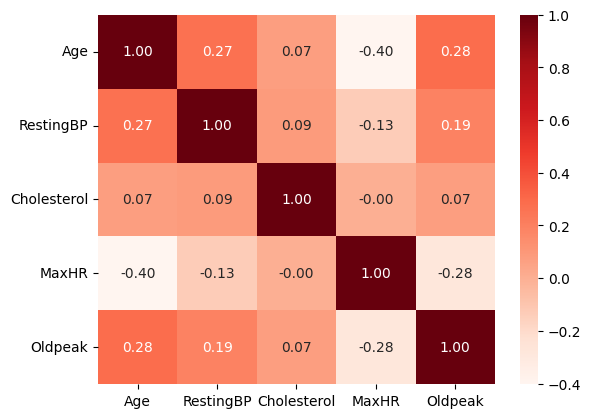

In [72]:
# continous - continous
selected_df_corr = df.loc[:,CONTINUOUS_COLUMNS]
correlation_matrix = selected_df_corr.corr()  # Calculate correlation matrix for numerical columns
sns.heatmap(correlation_matrix, cmap='Reds', annot=True, fmt='.2f')
plt.show()

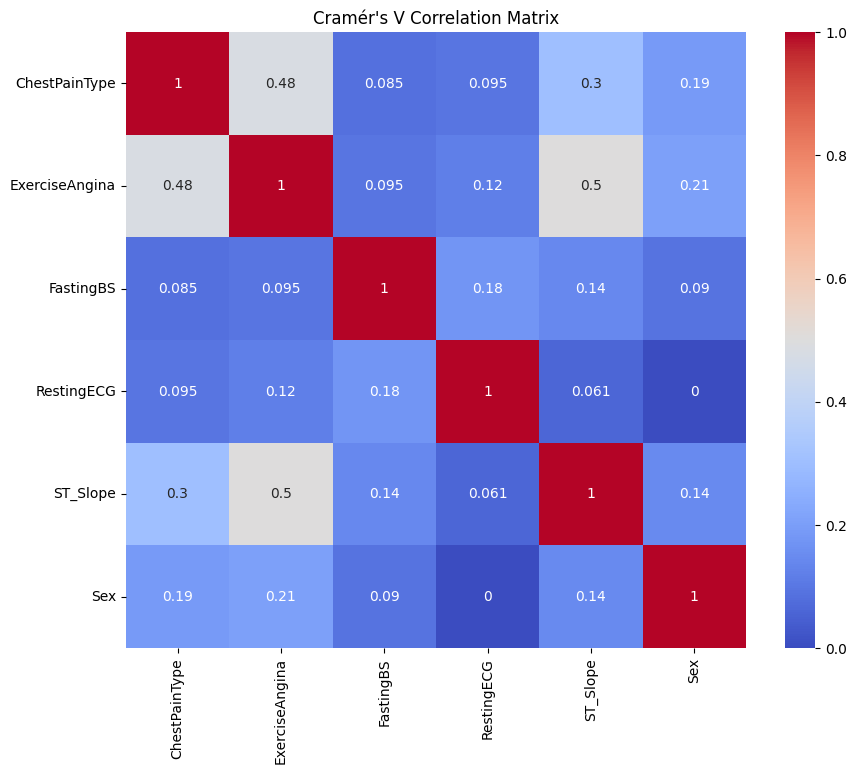

In [73]:
# Categorical - Categorical
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

categorical_features = df.loc[:, CATEGORICAL_COLUMNS]
corr_matrix = pd.DataFrame(np.zeros((len(categorical_features.columns), len(categorical_features.columns))), 
                           index=categorical_features.columns, columns=categorical_features.columns)

for col1 in categorical_features.columns:
    for col2 in categorical_features.columns:
        if col1 != col2:
            corr_matrix.loc[col1, col2] = cramers_v(categorical_features[col1], categorical_features[col2])
        else:
            corr_matrix.loc[col1, col2] = 1.0

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Cramér\'s V Correlation Matrix')
plt.show()

<Axes: xlabel='Age', ylabel='Oldpeak'>

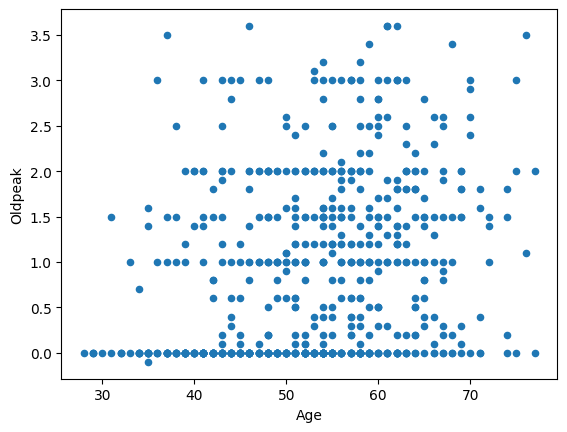

In [74]:
df.plot(kind='scatter', x='Age',y='Oldpeak')

Since the correlation between the numerical features is not strong, we decide not to exclude any of the features. Even the strongest correlation of them between the oldpeak and Age are not strong enough to exclude any of them.

### Feature Scaling

We opt for Standardization becauase: These features have different units (e.g., mmHg, mg/dL) and wide ranges. Standardization ensures they are on a comparable scale (mean 0, standard deviation 1) while preserving the shape of the distribution.

In [75]:
sc = StandardScaler()
df[CONTINUOUS_COLUMNS] = sc.fit_transform(df[CONTINUOUS_COLUMNS])
df[CONTINUOUS_COLUMNS]

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,-1.335169,0.547914,0.973199,1.291925,-0.866393
1,-0.390639,1.845825,-1.178909,0.634669,0.176309
2,-1.650013,-0.101041,0.854735,-1.747885,-0.866393
3,-0.495587,0.418123,-0.507609,-1.337100,0.697660
4,0.134100,1.196870,-0.882748,-0.762001,-0.866393
...,...,...,...,...,...
913,-0.810430,-1.398952,0.479596,-0.351215,0.384849
914,1.603369,0.807496,-0.922236,0.018491,2.678793
915,0.448943,-0.101041,-2.146371,-1.049550,0.384849
916,0.448943,-0.101041,-0.073239,1.374082,-0.866393


## PCA analysis

In [76]:

# Assuming 'df' is your DataFrame with scaled features
X = df[CONTINUOUS_COLUMNS]

# Apply PCA with 2 components
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print(f'Reserved variance in each component: {[f"{var:.2f}" for var in explained_variance_ratio]}')
print(f"Total variance Reserved across all components: {np.sum(explained_variance_ratio):.2f}")

Reserved variance in each component: ['0.36', '0.20', '0.17']
Total variance Reserved across all components: 0.74


## Clustering

In [77]:
# visua

## Model selection

## Model training

## Model evaluation

# Results

## Classification

# Discussion and Future Insight